In [1]:
from turbo import Turbo1
import torch
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import desc.io
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixCurrent,
    FixIota,
    FixPsi,
    AspectRatio,
    ForceBalance,
    QuasisymmetryTwoTerm,
    RotationalTransform
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
    plot_3d
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0+untagged.9460.gf2f5e85.dirty,using JAX backend, jax version=0.4.28, jaxlib version=0.4.28, dtype=float64
Using device: CPU, with 5.58 GB available memory


In [2]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val

f = Levy(10)

In [3]:
turboM = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Latin hypercube design
    max_evals = 1000,  # Maximum number of evaluations
    #n_trust_regions=1,
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=30,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


In [4]:
turboM.optimize()

Starting from fbest = 26.13
20) New best: 16.03
40) New best: 7.237
60) New best: 4.505
70) New best: 4.306
80) New best: 4.084
100) New best: 3.772
120) New best: 2.248
130) New best: 2.147
160) New best: 2.097
170) New best: 2.001
190) Restarting with fbest = 2.001
Starting from fbest = 31.12
450) Restarting with fbest = 3.942
Starting from fbest = 14.35
790) Restarting with fbest = 5.709
Starting from fbest = 30.39


In [5]:
X = turboM.X  # Evaluated points
fX = turboM.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

/tmp/ipykernel_50827/3390514463.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))


Best value found:
	f(x) = 2.001
Observed at:
	x = [-3.024  1.12   0.88  -4.23  -0.103 -0.157  0.808  0.988  0.545  0.826]


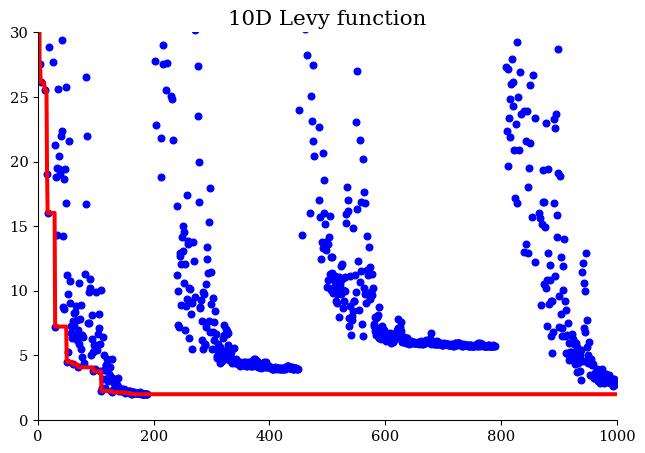

In [6]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.title("10D Levy function")

plt.tight_layout()
plt.show()